<h2>Purpose of this notebook:</h2>

<p>This notebook will introduce you to:
<ol>
<li>using charistools to create 3 surface Hypsometry partitions of MODIS MOD10A1 snowcover for the Hunza basin, using MODIS albedo data to partition the surface area into
<ol>
<li>snow-on-land,</li>
<li>snow-on-ice, and</li>
<li>exposed-glacier_ice</li>
</ol>
</ol>

<p>At the end of this lesson, you should be able to create the melt model Hypsometry input data for which you have basin_mask tiles.</p>

In [1]:
%pylab notebook
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from charistools.modelEnv import ModelEnv
configFile = '/Users/brodzik/2016_Almaty_training/modis_tiles_config.ini'
topDir = '/Users/brodzik/projects/CHARIS_FTP_copy/main_training/data'
myEnv = ModelEnv(tileConfigFile=configFile, topDir=topDir, verbose=True)

/Users/brodzik/.conda/envs/pmesdr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
charistools.modelEnv: read MODIS tile configuration from /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini

Populating the interactive namespace from numpy and matplotlib



charistools.modelEnv: model_top_dir changed to /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data
charistools.modelEnv: read MODIS tile configuration from /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini


<p>For the surface partitioning, we will use mod10a1 albedo data, so begin by looking for this type of data in the modis_tiles_config.ini file:</p>

In [2]:
%more /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini

<p>We will use MOD10A1_GF data for snow cover, and we will do the surface partition with the albedo data.  Like for the MOD10A1_GF data, you should be able to tell that we've classified albedo data as a forcing input file, and that you need a tileID and year to get a complete  albedo filename.  Like the MOD10A1_GF data, albedo is formatted as an .h5 "tile_cube," so the the charistools.readers ModisTileCube interface will be useful, and you'll need to know the variable name "varname" to tell it to read. </p>

In [3]:
albedoFile = myEnv.forcing_filename(type='albedo_mod10a1', tileID='h24v05', year=2001)
albedoFile

'/Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/mod10a1_albedo_gf/MOD10A1_GF_Albedo_shortwave.v0.5.h24v05_2001.h5'

<p>For more information about the albedo data, read the 00notes.txt file:</p>

In [4]:
%more /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/mod10a1_albedo_gf/00notes.txt

In [5]:
from netCDF4 import Dataset
f = Dataset(filename=albedoFile, mode='r', format='NETCDF4')
f

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 500m

In [6]:
f.groups['500m']

<type 'netCDF4._netCDF4.Group'>
group /500m:
    dimensions(sizes): phony_dim_0(365), phony_dim_1(2400)
    variables(dimensions): uint8 albedo_shortwave(phony_dim_0,phony_dim_1,phony_dim_1)
    groups: 

<p>So from the groups output, we can tell that the variable name to read is "albedo_shortwave"</p>

<p>Close the albedo file:</p>

In [7]:
f.close()

In [8]:
from charistools.readers import ModisTileCube
albedo_cube = ModisTileCube(albedoFile, varname='albedo_shortwave')

In [9]:
albedo = albedo_cube.read(doy=31)
print(albedo.shape)
print(np.amin(albedo), np.amax(albedo))

(2400, 2400)
0.0 1.0


<h3>Display one tile of shortwave albedo</h3>

<IPython.core.display.Javascript object>


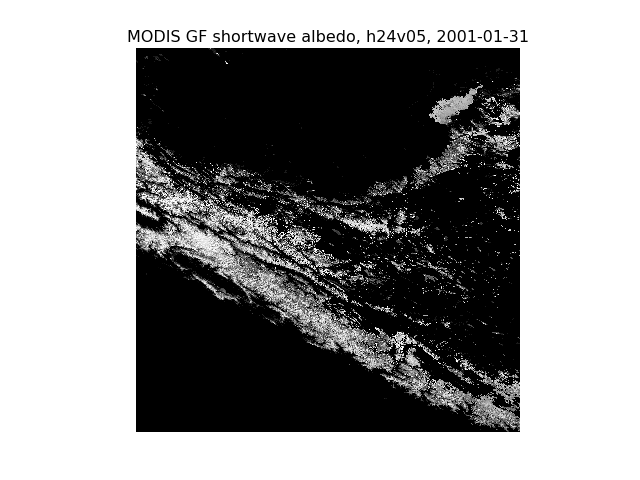

(-0.5, 2399.5, 2399.5, -0.5)

In [10]:
fig, ax = plt.subplots()
ax.imshow(albedo, cmap="Greys_r", vmin=0.0, vmax=1.0, interpolation='None')
ax.set_title('MODIS GF shortwave albedo, h24v05, 2001-01-31')
plt.axis('off')

<h3>Use the charistools.convertor tool to create the snow cover Hypsometry for the Hunza for 3 surfaces, where MODICE and albedo are used to discriminate snow-on-land, snow-on-ice and exposed-glacier-ice.</h3>

<p>Fsca2Hypsometry will do this operation, when you set fsca_area to different values.
</p>

<p>Here is the help message:</p>

In [11]:
from charistools.convertors import Fsca2Hypsometry
help(Fsca2Hypsometry)

Help on function Fsca2Hypsometry in module charistools.convertors:

Fsca2Hypsometry(drainageID, year, modelEnv, fsca_type='mod10a1_gf', fsca_area='total', ablation_method='albedo_mod10a1', threshold=0.46, start_doy=1, stop_doy=None, contour_m=100.0, outfile=None, decimal_places=2, verbose=False)
    Convert raster fractional SCA to Hypsometry for a specific
    drainageID.
    
    Uses input ModelEnv to read required input raster tile(s) for
    this drainageID and calculates fSCA_by_elevation at the requested
    contour levels.
    
    Default start/stop_doy are dates in the fSCA snow tile cube.
    
    Raises ValueError for invalid input combinations.
    Raises RuntimeError for errors reading input raster tile data.
    
    Args:
      drainageID: drainage name string to use in choosing input
        files to read, e.g. "IN_Hunza_at_Danyour" or "IN_Hunza_GDBD"
    
      year: integer, 4-digit year to use in choosing input files to
        read
    
      modelEnv: CHARIS Model

<p>We will use defaults for: contour level of 100 m, and fsca_type='mod10a1_gf'., but now we will use fsca_area='SOL', to get "snow on land".  Again, to start out let's just do 3 days at the beginning of the year.
</p>

<p>Remember that the routine finds the basin_mask files that modelEnv points to, and uses those tileIDs to read the DEM data, snow cover and produce the Hypsometry.  </p>

In [12]:
sol_hyps = Fsca2Hypsometry(drainageID="IN_Hunza_at_Danyour", year=2001, modelEnv=myEnv, 
                           fsca_area='SOL', stop_doy=3, verbose=True)

charistools.convertors : begin.
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h23v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h23v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/modicev04/MODICE.v0.4.h23v05.1strike.min05yr.mask.nc
TileID: h23v05, date: year=2001, doy= 1
TileID: h23v05, date: year=2001, doy= 2
TileID: h23v05, date: year=2001, doy= 3
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h24v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h24v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/modicev04/MODICE.v0.4.h

In [13]:
sol_hyps.print()

Hypsometry created : 2016-05-13 03:36:25.821540
Elevations in meters, contour at bottom of elevation band
Snow_on_land area in square km
Files used to derive this hypsometry data:
h23v05: basin_mask   : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h23v05.tif
h23v05: dem          : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h23v05.tif
h23v05: modice       : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/modicev04/MODICE.v0.4.h23v05.1strike.min05yr.mask.nc
h23v05: fSCA         : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/mod10a1_snow_gf/MOD10A1_GF_Snow.v0.5.h23v05_2001.h5
h24v05: basin_mask   : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h24v05.tif
h24v05: dem          : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h24v05.tif
h24v05: modice       : /Users/brodzik/project

<h3>Exercise</h3>

<p>Try running Fsca2Hypsometry 3 times, for each of fsca_area = 'SOL', 'SOI' and 'EGI'.  For 2001, and then use any of the Hypsometry display routines to look at all three sets of hypsometry data.  Do this for drainageID="IN_Hunza_at_Danyour" or for your own basin.
</p>

<p>The default albedo threshold for the SOI and EGI partition is 0.46, but you can change that if you want.</p>